In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
from tqdm import tqdm_notebook
import os

import data_processor
import importlib

In [32]:
data_processor = importlib.reload(data_processor)

In [4]:
t4_all = pd.read_table("../data_all_CDR/DL_4.txt")

In [6]:
t4_all.head()

,count,frequency,CDR3nt,CDR3aa,V,D,J,Vend,Dstart,Dend,Jstart
0,233,0.000789,TGCAGCGGGGGAGAAACCAAGGGGACCCAGTACTTC,CSGGETKGTQYF,TRBV29-1,TRBD2,TRBJ2-5,7,8,13,15
1,180,0.000609,TGTGCCAGCAGCTTGGGTTTAGCGGCCCGAGCTTTCTTT,CASSLGLAARAFF,TRBV7-2,TRBD2,TRBJ1-1,14,19,25,29
2,111,0.000376,TGTGCCAGCAGCTTAGTAGGTCTACAGACCTACGAGCAGTACTTC,CASSLVGLQTYEQYF,TRBV7-2,NaN,TRBJ2-7,16,-1,-1,28
3,81,0.000274,TGCGCCAGCAGCCAAAGGAGTTTCGGCACAGATACGCAGTATTTT,CASSQRSFGTDTQYF,TRBV4-3,NaN,TRBJ2-3,15,-1,-1,25
4,62,0.000210,TGTGCCTGGAGACCAACCTGGGACAGGGGCCGCACTGAAGCTTTCTTT,CAWRPTWDRGRTEAFF,TRBV30,TRBD1,TRBJ1-1,11,16,32,32


In [33]:
t4 = pd.read_table("../data_all_CDR/DL_4.txt", usecols=["count", "CDR3aa"])
t8 = pd.read_table("../data_all_CDR/DL_8.txt", usecols=["count", "CDR3aa"])

In [34]:
t4.head()
t8.head()

,count,CDR3aa
0,12940,CASSLFRTSYWDEQFF
1,1675,CASSLGYEQYF
2,1391,CASSLFRTSYWDEQFF
3,1291,CAWSVAGDGTDTQYF
4,929,CASSDLQGLAFEAFF


In [35]:
t4.shape

(239344, 2)

In [37]:
def to_seq_arrays(table_4, table_8, target_column):
    intersection = (set(table_4[target_column].values).intersection(table_8[target_column].values))
    
    table_4_filtred = [x for x in table_4[target_column].values if not x in intersection]
    table_8_filtred = [x for x in table_8[target_column].values if not x in intersection]
    
    table_4_intersection = np.concatenate([x.reshape(1, -1) for x in table_4.values if x[1] in intersection])
    table_8_intersection = np.concatenate([x.reshape(1, -1) for x in table_8.values if x[1] in intersection])


    print(table_4_intersection.shape)
    for el in tqdm_notebook(intersection):
        #print(table_4_intersection[:,2])
        #print(np.where(table_4_intersection[:,2] == el))
        #print(table_4_intersection[np.where(table_4_intersection[:,2] == el)[0]])
        i4 = np.array(np.where(table_4_intersection[:,1] == el)[0])
        i8 = np.array(np.where(table_8_intersection[:,1] == el)[0])

        if table_4_intersection[i4,0].sum() > table_8_intersection[i8,0].sum():
            table_4_filtred.append(el)
        else:
            table_8_filtred.append(el)
            
    return table_4_filtred, table_8_filtred

In [38]:
t4_f, t8_f = to_seq_arrays(t4, t8, "CDR3aa")

(12333, 2)


A Jupyter Widget

In [8]:
len(t4_f)

342111

In [9]:
set(t4_f).intersection(set(t8_f))

set()

In [12]:
np.save("../data/DL_4_u_CDR3", np.array(t4_f))
np.save("../data/DL_8_u_CDR3", np.array(t8_f))

In [13]:
y_f = np.array([0] * len(t4_f) + [1] * len(t8_f))
t_f = t4_f + t8_f

## Prepare RNN/Transformer dataset

In [16]:
l_to_n = dict(zip(sorted(kidera.index.values), np.arange(1,kidera.index.values.shape[0] + 1)))

In [17]:
l_to_n["_BOS_"] = 21
l_to_n["_EOS_"] = 22
l_to_n["_EMP_"] = 0

In [18]:
l_to_n.keys()

dict_keys(['M', 'P', '_BOS_', 'K', 'N', 'S', '_EOS_', 'C', 'T', 'D', '_EMP_', 'Y', 'Q', 'G', 'H', 'W', 'F', 'E', 'L', 'I', 'R', 'A', 'V'])

In [19]:
l_to_n

{'A': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'P': 13,
 'Q': 14,
 'R': 15,
 'S': 16,
 'T': 17,
 'V': 18,
 'W': 19,
 'Y': 20,
 '_BOS_': 21,
 '_EMP_': 0,
 '_EOS_': 22}

In [20]:
def CDR_to_num_array(seq, dictionary, array_len):
    seq_arr = np.zeros(array_len, dtype = np.int8)
    
    seq_arr[0] = dictionary["_BOS_"]
    for i, symbol in enumerate(seq):
        seq_arr[i + 1] = dictionary[symbol]
    seq_arr[i + 2] = dictionary["_EOS_"]
    
    return seq_arr

In [21]:
max_len = max([len(x) for x in t_f]) + 2
max_len

26

In [22]:
RNN_data_as_list = [CDR_to_num_array(x, l_to_n, max_len) for x in tqdm_notebook(t_f)]

A Jupyter Widget

In [23]:
RNN_data = np.concatenate([x.reshape(1,-1) for x in RNN_data_as_list])

In [24]:
np.save("../data/DL_RNN_data_filtred", RNN_data)
np.save("../data/DL_RNN_data_filtred_y", np.array(y_f))

In [25]:
len(y_f)

358476

In [27]:
y_f.sum()

129172

In [26]:
RNN_data.shape

(358476, 26)

In [28]:
import pickle

In [29]:
pickle.dump(l_to_n, open("../data/l_to_n", "wb"))

In [45]:
len((t_f))

504191

## Try bigrams

In [12]:
from nltk import bigrams, ngrams

In [17]:
calc_ngrams = lambda y, n : [''.join(x) for x in ngrams(y, n)]

In [18]:
def all_ngrams(X, n):
    all_ngrams = dict()
    for x in tqdm_notebook(X):
        for ngramm in calc_ngrams(x,n):
            if ngramm in all_ngrams.keys():
                all_ngrams[ngramm] += 1
            else:
                all_ngrams[ngramm] = 1
                
    return all_ngrams

In [19]:
def prepare_ngrams_table()

SyntaxError: invalid syntax (<ipython-input-19-caaa86665359>, line 1)

In [32]:
s4_3 = all_ngrams(t4["aaSeqCDR3"].values[:], 3)
s8_3 = all_ngrams(t8["aaSeqCDR3"].values[:], 3)

A Jupyter Widget

A Jupyter Widget

In [66]:
counter = 0
for trig in s8_3.keys():
    if not trig in intersection_3:
        counter += s8_3[trig]
print("c", counter)

c 164


In [35]:
intersection_3 = set(s4_3.keys()).intersection(set(s8_3.keys()))

In [37]:
intersection_with_counts = pd.DataFrame(columns = [4,8], index=sorted(list(intersection_3)))

In [39]:
for ngramm in tqdm_notebook(intersection_3):
    intersection_with_counts.loc[ngramm, 4] = s4_3[ngramm]
    intersection_with_counts.loc[ngramm, 8] = s8_3[ngramm]

intersection_with_counts[4] = intersection_with_counts[4] / intersection_with_counts[4].sum()
intersection_with_counts[8] = intersection_with_counts[8] / intersection_with_counts[8].sum()

A Jupyter Widget

In [71]:
intersection_with_counts[4] = intersection_with_counts[4] / intersection_with_counts[4].sum()
intersection_with_counts[8] = intersection_with_counts[8] / intersection_with_counts[8].sum()

In [73]:
def plot_bar_part(table, start, end):
    plt.bar(np.arange(end-start), intersection_with_counts[start:end][4], alpha = 0.5)
    plt.bar(np.arange(end-start), intersection_with_counts[start:end][8],  alpha = 0.5)
    plt.show()

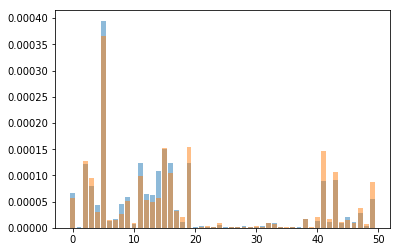

In [75]:
plot_bar_part(intersection_with_counts, 0, 50)

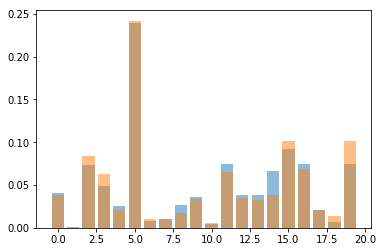

In [49]:
plt.bar(np.arange(20), intersection_with_counts[:20][4] / sum(intersection_with_counts[:20][4]), alpha = 0.5)
plt.bar(np.arange(20), intersection_with_counts[:20][8] / sum(intersection_with_counts[:20][8]),  alpha = 0.5)
plt.show()

In [20]:
s4_1 = all_ngrams(t4["CDR3nt"].values, 1)
s8_1 = all_ngrams(t8["CDR3nt"].values, 1)

A Jupyter Widget

A Jupyter Widget

In [21]:
s1 = set(s4_1.keys()).union(set(s8_1.keys()))

In [24]:
t4["CDR3nt"]

0             TGTGCCAGCAGTTACTCGGGACAGGTCAACAATGAGCAGTTCTTC
1                TGTGCCATCAGTGGGGACCGGGATGGTAATGAGCAGTTCTTC
2             TGTGCCAGCAGTGACCGGGACACTACAAACTATGGCTACACCTTC
3                      TGTGCCAGCAGTCTCAAACTATATGGCTACACCTTC
4                   TGTGCCAGCAGCTTAATGCGTCAAGAGACCCAGTACTTC
5                      TGTGCCAGCAGTTTGGCAGCGGGGGACTACACCTTC
6                   TGCAGTGCTTCCGGACACTTGAACACTGAAGCTTTCTTT
7                      TGTGCCAGCAGTGAAAAAAGCTACGAGCAGTACTTC
8                   TGTGCCATCAGTGAGGGCAGGGCCTACGAGCAGTACTTC
9             TGTGCCAGCAGCTTAAGTTTATTGGGCATTTATGGCTACACCTTC
10         TGTGCCAGCAGCGACCGCGGGACAGTAATGAACACTGAAGCTTTCTTT
11         TGTGCCACCAGTGATTTGACTGGGGGAGTCGAAGAGACCCAGTACTTC
12                     TGCAGTGCTCCCTCCCTAGCAGCCGAGCAGTTCTTC
13         TGTGCCAGCAGCCCCCATCGGTCCACGGGGGCCGGGGAGCTGTTTTTT
14               TGCGCCAGCAGAGCGGAGGGGGAAGGCACTGAAGCTTTCTTT
15                  TGTGCCAGCAGCCGGACAGGGAAAAACATTCAGTACTTC
16               TGCAGTGCTAGAAAGGCAGGGAC

In [22]:
d1 = dict(zip(sorted(list(s1)), range(len(s1))))

In [23]:
d1

{'A': 0, 'C': 1, 'G': 2, 'T': 3}

## Emb

In [39]:
kidera = pd.DataFrame(list(map(lambda x: x.split(","), "A,-1.56,-1.67,-0.97,-0.27,-0.93,-0.78,-0.2,-0.08,0.21,-0.48;R,0.22,1.27,1.37,1.87,-1.7,0.46,0.92,-0.39,0.23,0.93;N,1.14,-0.07,-0.12,0.81,0.18,0.37,-0.09,1.23,1.1,-1.73;D,0.58,-0.22,-1.58,0.81,-0.92,0.15,-1.52,0.47,0.76,0.7;C,0.12,-0.89,0.45,-1.05,-0.71,2.41,1.52,-0.69,1.13,1.1;Q,-0.47,0.24,0.07,1.1,1.1,0.59,0.84,-0.71,-0.03,-2.33;E,-1.45,0.19,-1.61,1.17,-1.31,0.4,0.04,0.38,-0.35,-0.12;G,1.46,-1.96,-0.23,-0.16,0.1,-0.11,1.32,2.36,-1.66,0.46;H,-0.41,0.52,-0.28,0.28,1.61,1.01,-1.85,0.47,1.13,1.63;I,-0.73,-0.16,1.79,-0.77,-0.54,0.03,-0.83,0.51,0.66,-1.78;L,-1.04,0,-0.24,-1.1,-0.55,-2.05,0.96,-0.76,0.45,0.93;K,-0.34,0.82,-0.23,1.7,1.54,-1.62,1.15,-0.08,-0.48,0.6;M,-1.4,0.18,-0.42,-0.73,2,1.52,0.26,0.11,-1.27,0.27;F,-0.21,0.98,-0.36,-1.43,0.22,-0.81,0.67,1.1,1.71,-0.44;P,2.06,-0.33,-1.15,-0.75,0.88,-0.45,0.3,-2.3,0.74,-0.28;S,0.81,-1.08,0.16,0.42,-0.21,-0.43,-1.89,-1.15,-0.97,-0.23;T,0.26,-0.7,1.21,0.63,-0.1,0.21,0.24,-1.15,-0.56,0.19;W,0.3,2.1,-0.72,-1.57,-1.16,0.57,-0.48,-0.4,-2.3,-0.6;Y,1.38,1.48,0.8,-0.56,0,-0.68,-0.31,1.03,-0.05,0.53;V,-0.74,-0.71,2.04,-0.4,0.5,-0.81,-1.07,0.06,-0.46,0.65".split(";"))), index=["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"], columns=["aminoacid"] + list(map(lambda x: "f"+str(x), range(1,11))))

In [145]:
kidera.to_csv("../data/kidera")

## Constanter classifiers

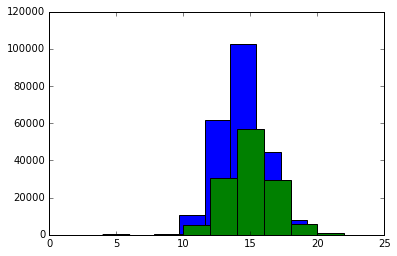

In [40]:
plt.hist([len(x) for x  in t4_f])
plt.hist([len(x) for x  in t8_f])
plt.show()

In [41]:
def process_seq(seq, l):
    if len(seq) > l:
        return seq[int((len(seq) - l)/ 2) : int((len(seq) + l) / 2)]
    else:
        seq2 = "___________" + seq + "___________"
        return seq2[int((len(seq2) - l)/ 2) : int((len(seq2) + l) / 2)]

In [42]:
L = 13
fixed_len4 = [process_seq(x, L) for x  in t4_f]
fixed_len8 = [process_seq(x, L) for x  in t8_f]

In [ ]:
fix

In [43]:
def process_fixed_len(seq, d):
    ans = np.zeros(len(d) * len(seq))
    for i, letter in enumerate(seq):
        if letter in d:
            ans[i * len(d) + d[letter]] = 1
    return ans

In [45]:
one_hot_4 = np.concatenate([process_fixed_len(x, l_to_n).reshape(1,-1) for x in fixed_len4[:]])
one_hot_8 = np.concatenate([process_fixed_len(x, l_to_n).reshape(1,-1) for x in fixed_len8[:]])

In [47]:
one_hot_8.shape

(129172, 299)

In [49]:
len(t8_f)

129172

In [50]:
#y = one_hot_4.shape[0] * [0] + one_hot_8.shape[0] * [1]
one_hot_X = np.vstack((one_hot_4, one_hot_8))

In [51]:
np.save("../data/DL_one_hot_13", one_hot_X)
#np.save("./LY_one_hot_15_y", np.array(y))

## fixed_len to Kidera

In [68]:
kidera_dict["C"]

array(['0.12', '-0.89', '0.45', '-1.05', '-0.71', '2.41', '1.52', '-0.69',
       '1.13', '1.1'], dtype=object)

In [62]:
kidera_dict = dict(zip(kidera.values[:,0], kidera.values[:, 1:]))
kidera_dict["_"] = np.zeros_like(kidera_dict["A"])

In [63]:
def fixed_len_to_repr(seq, d):
    answ = np.zeros((d["A"].shape[0], len(seq)))
    
    for i, letter in enumerate(seq):
        answ[:,i] = d[letter]
    return answ

In [64]:
fixed_len4[0]

'_CSGGETKGTQYF'

In [74]:
fixed_len_to_repr(fixed_len4[0], kidera_dict)

array([[ 0.  ,  0.12,  0.81,  1.46,  1.46, -1.45,  0.26, -0.34,  1.46,
         0.26, -0.47,  1.38, -0.21],
       [ 0.  , -0.89, -1.08, -1.96, -1.96,  0.19, -0.7 ,  0.82, -1.96,
        -0.7 ,  0.24,  1.48,  0.98],
       [ 0.  ,  0.45,  0.16, -0.23, -0.23, -1.61,  1.21, -0.23, -0.23,
         1.21,  0.07,  0.8 , -0.36],
       [ 0.  , -1.05,  0.42, -0.16, -0.16,  1.17,  0.63,  1.7 , -0.16,
         0.63,  1.1 , -0.56, -1.43],
       [ 0.  , -0.71, -0.21,  0.1 ,  0.1 , -1.31, -0.1 ,  1.54,  0.1 ,
        -0.1 ,  1.1 ,  0.  ,  0.22],
       [ 0.  ,  2.41, -0.43, -0.11, -0.11,  0.4 ,  0.21, -1.62, -0.11,
         0.21,  0.59, -0.68, -0.81],
       [ 0.  ,  1.52, -1.89,  1.32,  1.32,  0.04,  0.24,  1.15,  1.32,
         0.24,  0.84, -0.31,  0.67],
       [ 0.  , -0.69, -1.15,  2.36,  2.36,  0.38, -1.15, -0.08,  2.36,
        -1.15, -0.71,  1.03,  1.1 ],
       [ 0.  ,  1.13, -0.97, -1.66, -1.66, -0.35, -0.56, -0.48, -1.66,
        -0.56, -0.03, -0.05,  1.71],
       [ 0.  ,  1.1 , -0.23,

In [70]:
kidera_4 = np.concatenate([fixed_len_to_repr(x, kidera_dict).reshape(1,-1) for x in fixed_len4[:]])
kidera_8 = np.concatenate([fixed_len_to_repr(x, kidera_dict).reshape(1,-1) for x in fixed_len8[:]])

In [72]:
kidera_data = np.vstack((kidera_4, kidera_8))

In [73]:
np.save("../data/kidera_13_data", kidera_data)

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [8]:
one_hot_X = np.load("./LY_one_hot_15.npy")
y = np.load("./LY_one_hot_15_y.npy")

In [80]:
train_X, test_X, train_y,  test_y = train_test_split(one_hot_X, y)
    

In [81]:
lr = LogisticRegression(verbose= 1)
lr.fit(train_X, train_y)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

In [82]:
accuracy_score(test_y, lr.predict(test_X))

0.69119091802205

In [ ]:
svm = SVC()
svm.fit(train_X, train_y)

In [ ]:
accuracy_score(test_y, svm.predict(test_X))

## CHECK

In [160]:
ly_322 = np.load("../data/322_LY/LY_RNN.npy")

In [161]:
ly = np.load("../data/LY_/RNN_data_filtred.npy")

In [170]:
ly_322[0]

array([21,  2,  1, 16, 16, 14, 13,  6,  6,  3, 12,  4,  9, 10,  5,  5, 22,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int8)

In [171]:
ly[0]

array([21,  2,  1, 16, 16, 14, 13,  6,  6,  3, 12,  4,  9, 10,  5,  5, 22,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int8)